# Laptop Price estimation using Machine Learning
### Reading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('laptopPrice.csv')
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              823 non-null    object
 1   processor_brand    823 non-null    object
 2   processor_name     823 non-null    object
 3   processor_gnrtn    823 non-null    object
 4   ram_gb             823 non-null    object
 5   ram_type           823 non-null    object
 6   ssd                823 non-null    object
 7   hdd                823 non-null    object
 8   os                 823 non-null    object
 9   os_bit             823 non-null    object
 10  graphic_card_gb    823 non-null    object
 11  weight             823 non-null    object
 12  warranty           823 non-null    object
 13  Touchscreen        823 non-null    object
 14  msoffice           823 non-null    object
 15  Price              823 non-null    int64 
 16  rating             823 non-null    object
 1

## Data Cleaning

- Let us extract the values from the texts (objects) in processor name, generations, ram, ssd, graphic_card_gb,warranty,os_bit and ratings. The goal is to make the datas clean and no numerical values mixed with string values on the same columns.
- The datatype of those columns must also be formated as float

In [5]:
remove_gb = lambda x: x.replace('GB','')
df['ram_gb']=df['ram_gb'].apply(remove_gb)
remove_th = lambda x: x.replace('th','')
df.processor_gnrtn=df.processor_gnrtn.apply(remove_th)
df.graphic_card_gb = df.graphic_card_gb.apply(remove_gb)
df.ssd = df.ssd.apply(remove_gb)
df.hdd = df.hdd.apply(remove_gb)
remove_stars = lambda x: x.replace('stars','')
df.rating=df.rating.apply(remove_stars)

In [6]:
def warranty_to_num(x):
    x = x.replace('year','')
    x = x.replace('s','')
    if 'No' in x.split():
        y = 0
    else:
        y = x
    return int(y)

df.warranty = df.warranty.apply(warranty_to_num)

In [7]:
df.warranty.unique()

array([0, 1, 2, 3])

In [8]:
def create_corei(x):
    x = str(x)
    if('Core i' in x):
        x = x.replace('Core i','')
        return float(x)
    else:
        return np.nan

In [9]:
df['processor_name'].value_counts()

Core i5         290
Core i3         164
Core i7         110
Ryzen 5          82
Ryzen 7          56
Ryzen 3          26
Ryzen 9          26
Celeron Dual     24
M1               24
Pentium Quad     13
Core i9           8
Name: processor_name, dtype: int64

In [10]:
df.rating = df.rating.apply(lambda x: x.replace('star',''))

In [11]:
num = ['ram_gb','processor_gnrtn','ssd','hdd','os_bit','graphic_card_gb','warranty','rating','Number of Ratings','Number of Reviews','core_i']

In [12]:
df['processor_gnrtn'].value_counts()

11               334
Not Available    225
10               204
8                 41
7                  9
9                  6
12                 3
4                  1
Name: processor_gnrtn, dtype: int64

There are 225 "Not Available" processor generation. Let us see which type of processor are those unknown

In [13]:
df['processor_name'][df['processor_gnrtn']=='Not Available'].value_counts()

Ryzen 5         78
Ryzen 7         56
Ryzen 3         26
Ryzen 9         26
Celeron Dual    24
Pentium Quad    13
Core i5          2
Name: processor_name, dtype: int64

Here we have 251 "Core i" processors and 225 

223/225 non core_i processors are unknown generations. So for the non-corei processors, they does not have known generations.

In [14]:
df['processor_name'][df['processor_gnrtn']!='Not Available'].value_counts()

Core i5    288
Core i3    164
Core i7    110
M1          24
Core i9      8
Ryzen 5      4
Name: processor_name, dtype: int64

- For the non-corei processor, 24 M1 and 4 Ryzen 5 has known generation
- So let us divide our dataset in three types: Corei Processor, Ryzen, and others

In [15]:
class proc_features():
    def __init__(self, feature=None):
        self.feature=feature
    
    def create(self,x):
        x = str(x)
        if(self.feature in x):
            x = x.replace(self.feature,'')
            return float(x)
        else:
            return np.nan

In [16]:
df['processor_name'].value_counts()

Core i5         290
Core i3         164
Core i7         110
Ryzen 5          82
Ryzen 7          56
Ryzen 3          26
Ryzen 9          26
Celeron Dual     24
M1               24
Pentium Quad     13
Core i9           8
Name: processor_name, dtype: int64

In [17]:
corei = proc_features(feature='Core i')
ryzen = proc_features(feature='Ryzen')

In [18]:
df['proc_corei']=df['processor_name'].apply(corei.create)

In [19]:
df['proc_ryzen']=df['processor_name'].apply(ryzen.create)

In [20]:
df.os.value_counts()

Windows    779
Mac         28
DOS         16
Name: os, dtype: int64

Most of the computer has windows operating system. Just the APPLE will have the MacOS and the DOS is very rare.
Let us also drop this column 

In [21]:
df.os_bit.value_counts()

64-bit    714
32-bit    109
Name: os_bit, dtype: int64

For any common cases, Most of computers has 64 bits OS system installed. It is also easy for the sales person or the technicians to switch the OS based on the customers preference. It could be better if we remove that column.

In [22]:
df.os_bit=df.os_bit.str.replace('-bit','').astype('float64')

In [23]:
df.rating=df.rating.str.replace(' s','').astype('float64')

## Exploratory Data Analysis 

In [24]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,...,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews,proc_corei,proc_ryzen
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64.0,...,Casual,0,No,No,34649,2.0,3,0,3.0,NaN
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64.0,...,Casual,0,No,No,38999,3.0,65,5,3.0,NaN
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64.0,...,Casual,0,No,No,39999,3.0,8,1,3.0,NaN
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32.0,...,Casual,0,No,No,69990,3.0,0,0,5.0,NaN
4,ASUS,Intel,Celeron Dual,Not Available,4,DDR4,0,512,Windows,64.0,...,Casual,0,No,No,26990,3.0,0,0,NaN,NaN


In [25]:
cat = ['brand','processor_brand','processor_name','os','weight','Touchscreen','msoffice']
num = ['proc_corei','proc_ryzen','processor_gnrtn','ram_gb','ssd','hdd','warranty','graphic_card_gb','Price','rating','Number of Ratings','Number of Reviews']

In [26]:
df.processor_gnrtn=df.processor_gnrtn.str.replace('Not Available','NaN').astype('float64')

In [27]:
df[cat]=df[cat].astype('category')
df[num]=df[num].astype('float64')

<AxesSubplot:xlabel='proc_corei', ylabel='count'>

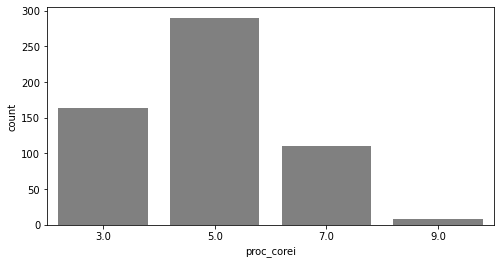

In [36]:
plt.figure(figsize=(8,4))
sns.countplot(x=df.proc_corei,color='gray')

<AxesSubplot:xlabel='proc_ryzen', ylabel='count'>

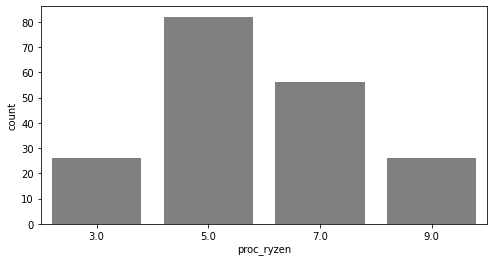

In [37]:
plt.figure(figsize=(8,4))
sns.countplot(x=df.proc_ryzen,color='gray')

The data has 80 Ryzen5 processor machines and around 60 ryzen 7 processors.

<AxesSubplot:xlabel='brand', ylabel='count'>

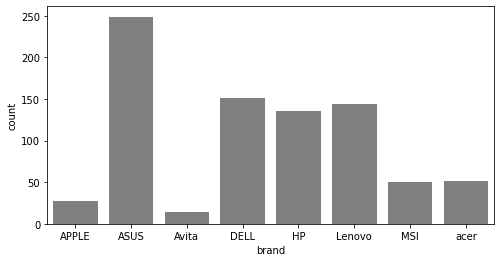

In [40]:
plt.figure(figsize=(8,4))
sns.countplot(x=df.brand,color='gray')

<AxesSubplot:xlabel='processor_brand', ylabel='count'>

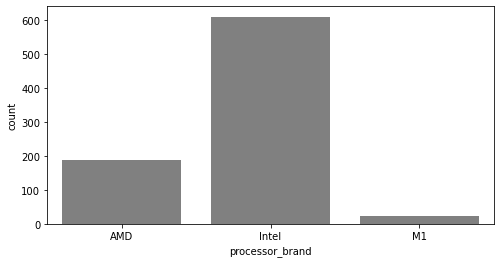

In [41]:
plt.figure(figsize=(8,4))
sns.countplot(x=df.processor_brand,color='gray')

As expected, Intel will have the most count. And M1 is small since it is the most expensive (MacOS machine)

In [32]:
df.processor_brand.value_counts()

Intel    610
AMD      189
M1        24
Name: processor_brand, dtype: int64

<AxesSubplot:xlabel='processor_name', ylabel='count'>

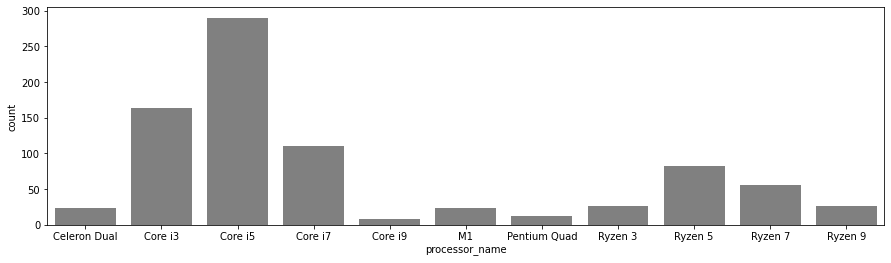

In [42]:
plt.figure(figsize=(15,4))
sns.countplot(x=df.processor_name,color='gray')

<AxesSubplot:xlabel='processor_gnrtn', ylabel='count'>

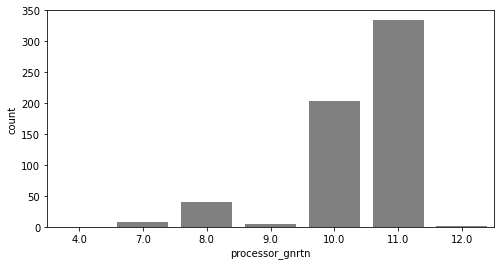

In [43]:
plt.figure(figsize=(8,4))
sns.countplot(x=df.processor_gnrtn,color='gray')

11th generation has the most counts in the data. 11th generation is best uses for gaming purposes and high end computational loads

<AxesSubplot:>

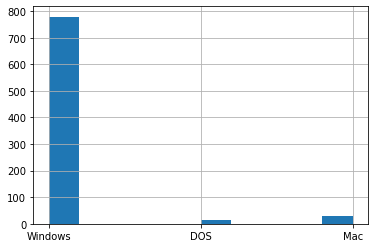

In [44]:
df['os'].hist()

Most of the computers are windows. Mac OS is only for the Apple brand.

<AxesSubplot:>

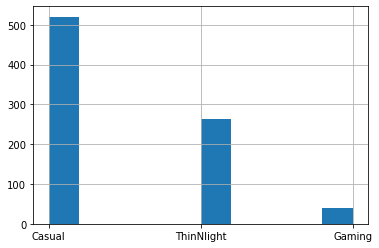

In [45]:
df.weight.hist()

In [46]:
len(num)

12

Casual is about 500 of them, ThinNlight about 270 and few of them are gaming.

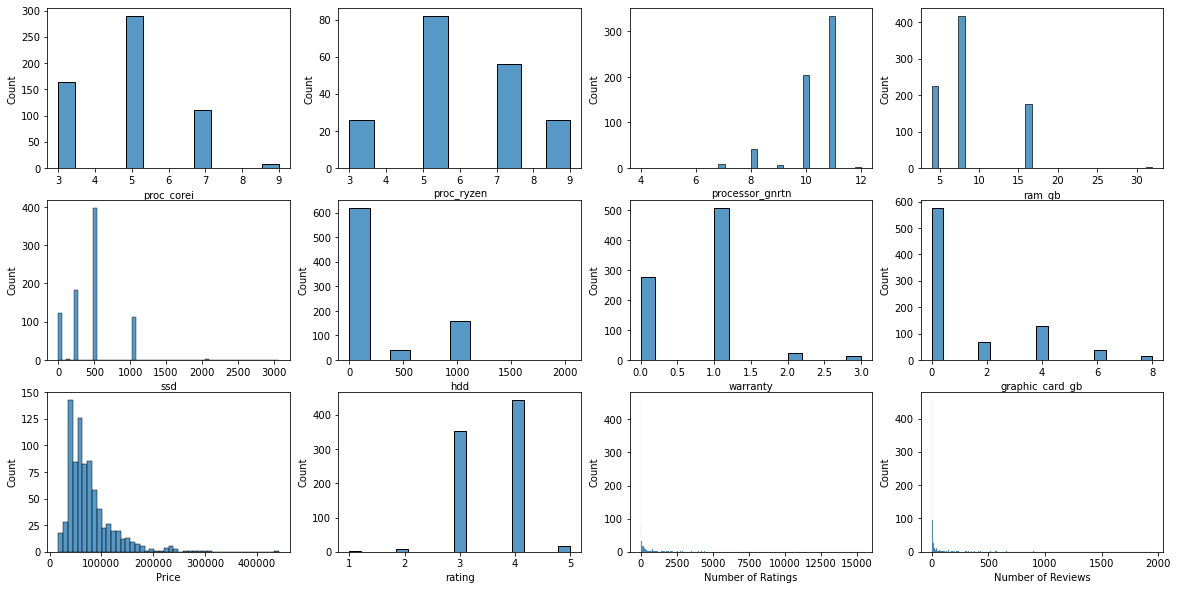

In [47]:
fig, ax = plt.subplots(3,4,figsize=(20,10))
ax = ax.flatten()
for i in range(len(num)):
    sns.histplot(x=df[num[i]],ax=ax[i])

<AxesSubplot:xlabel='proc_corei', ylabel='Price'>

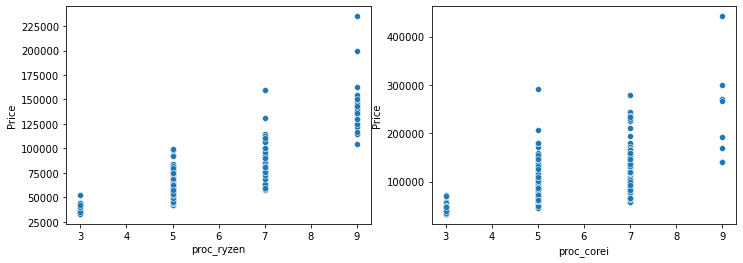

In [48]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax = ax.flatten()
sns.scatterplot(x=df['proc_ryzen'],y=df['Price'],ax=ax[0])
sns.scatterplot(x=df['proc_corei'],y=df['Price'],ax=ax[1])

Here we see some patterns that the price rises when the processor rises. It is an indicative of correlations between processor and the price

<AxesSubplot:xlabel='ram_gb', ylabel='Price'>

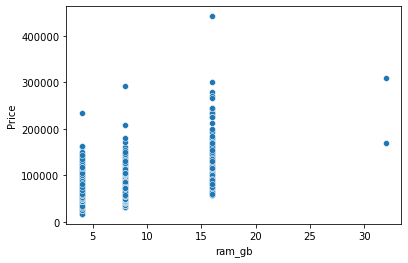

In [49]:
sns.scatterplot(x=df['ram_gb'],y=df['Price'])

<AxesSubplot:xlabel='processor_gnrtn', ylabel='Price'>

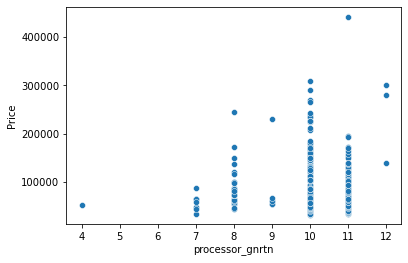

In [50]:
sns.scatterplot(x=df['processor_gnrtn'],y=df['Price'])

<AxesSubplot:xlabel='proc_corei', ylabel='Price'>

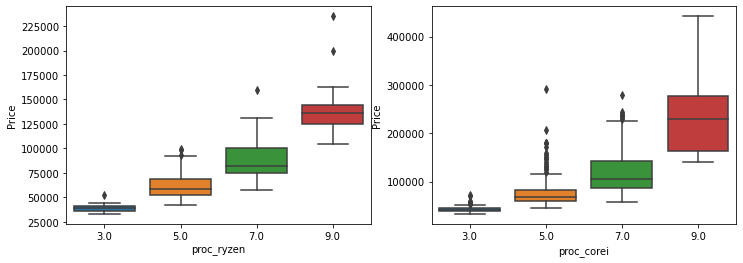

In [51]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax = ax.flatten()
sns.boxplot(x=df['proc_ryzen'],y=df['Price'],ax=ax[0])
sns.boxplot(x=df['proc_corei'],y=df['Price'],ax=ax[1])

<AxesSubplot:xlabel='proc_corei'>

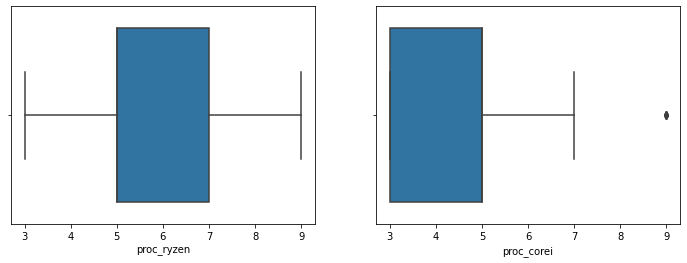

In [52]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax = ax.flatten()
sns.boxplot(x=df['proc_ryzen'],ax=ax[0])
sns.boxplot(x=df['proc_corei'],ax=ax[1])

In [53]:
df_r = df[df['proc_ryzen'].isna()==False].drop(['proc_corei','processor_name','processor_brand','processor_gnrtn'],axis=1).copy()

In [54]:
df_c = df[df['proc_corei'].isna()==False].drop(['proc_ryzen','processor_name','processor_brand'],axis=1).copy()

# Model Building

### Predict the price for Core i Processor

For the model building part, we will train a Ridge Regression model. Before feeding the model, the data is Preprocessed as follow:
- Numerical features are scaled using RobustScaler (based on their median and their IQR) to limits the outliers effects
- Categorical Variables are encoded via OneHotEncoder
- We will use PCA to reduce the multicollinearity effect between the input variables
Then we train the model. Those steps are inside a Scikit-Learn pipeline in order to avoid Data Leakage.

Finally the trained model will be optimized to find the best "alpha" coefficient using a Grid-Search algorithm.

"Learning Curves" shows how our model is performing as the input data grows. It shows if the model overfits the training set or not.

In [55]:
df_c = df_c.dropna().drop_duplicates()

<AxesSubplot:>

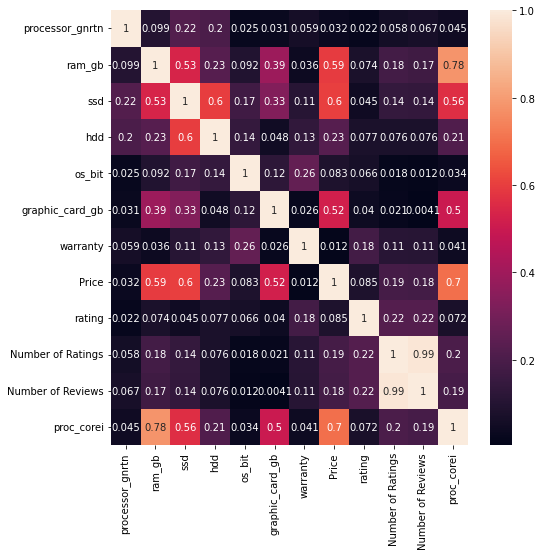

In [56]:
plt.figure(figsize=(8,8))
sns.heatmap(abs(df_c.corr()),annot=True)

In [80]:
X = df_c.drop('Price',axis=1)
y = df_c.Price

In [81]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.preprocessing import RobustScaler,OneHotEncoder,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

In [82]:
num_selector = make_column_selector(dtype_include='float64')
cat_selector = make_column_selector(dtype_exclude='float64')

In [83]:
transformer_pipeline = make_column_transformer((RobustScaler(),num_selector),(OneHotEncoder(handle_unknown='ignore'),cat_selector))
pca = make_pipeline(MinMaxScaler(),PCA(random_state=33,whiten=True))
preproc = make_pipeline(transformer_pipeline)

In [84]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,y,shuffle=True,random_state=33,test_size=0.2)

In [85]:
ridge = make_pipeline(preproc,Ridge())
ridge.fit(X_train,Y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('robustscaler',
                                                                   RobustScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7ff860394040>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7ff860954f10>)]))])),
                ('ridge', Ridge())])

In [86]:
ridge.score(X_train,Y_train)

0.7661766500069219

In [87]:
ridge.score(X_test,Y_test)

0.7263632182046327

In [88]:
from sklearn.model_selection import learning_curve
def plot_learning_curves(model):
    (N,train_score,val_score)=learning_curve(estimator=model,X=X_train,y=Y_train,cv=5,scoring='r2',n_jobs=4)
    train_score=train_score.mean(axis=1)
    val_score=val_score.mean(axis=1)
    plt.plot(N,train_score,color='orange',label='train_score')
    plt.plot(N,val_score,color='blue',label='val_score')
    plt.grid()
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend()
    

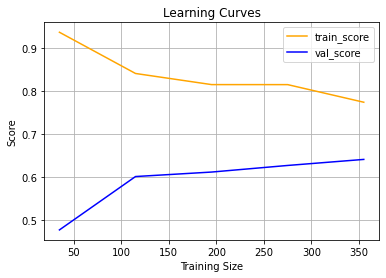

In [89]:
plot_learning_curves(ridge)

In [90]:
from sklearn.model_selection import GridSearchCV

grid = {'ridge__alpha':[0.01,0.1,0.2,0.5,0.9,1.3,1.6,1.9,2]}

gs = GridSearchCV(estimator=ridge,param_grid=grid,scoring='r2',n_jobs=4)
gs.fit(X_train,Y_train)
print(gs.best_params_)
print(gs.best_score_)
ridge = gs.best_estimator_

{'ridge__alpha': 0.5}
0.6417734930854163


In [91]:
ridge.score(X_test,Y_test)

0.7270374842363514

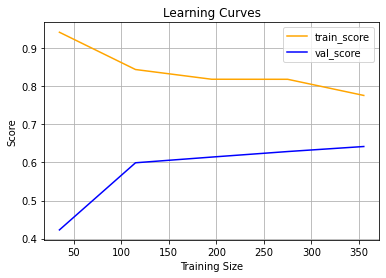

In [92]:
plot_learning_curves(ridge)

# Conclusion:
As the number of training data may grow, the model will perform good. From our number of training records, we can still appreciate the models performance of having R2 score of 72%.
Predicting laptop price based on the computers features is still challenging because there are many other parameters that may affect the price such as geographical locations, taxes and their price is going through the years.

## Saving the model

In [77]:
import joblib
joblib.dump(value=ridge,filename='ridge.p')

['ridge.p']

In [94]:
X_train.columns

Index(['brand', 'processor_gnrtn', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'os',
       'os_bit', 'graphic_card_gb', 'weight', 'warranty', 'Touchscreen',
       'msoffice', 'rating', 'Number of Ratings', 'Number of Reviews',
       'proc_corei'],
      dtype='object')

AttributeError: 'Series' object has no attribute 'uniques'